In [ ]:
import yaml
from typing import List, Dict
from sklearn.model_selection import train_test_split
import uproot
import os
import glob
import xgboost as xgb
<<<<<<< local
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
=======
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, hinge_loss, confusion_matrix
>>>>>>> remote
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
<<<<<<< local
=======
import tensorflow as tf
>>>>>>> remote
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
tf.config.list_physical_devices('GPU')


W0000 00:00:1753130441.213831  202421 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

### tf.keras

In [6]:
<<<<<<< local
=======
# unfinished work on trying NN with tf.keras

>>>>>>> remote
import tensorflow as tf

def mlpClassifier(input_df, outputs):
    input_hits = tf.keras.Input(input_df)

    x = tf.keras.layers.Dense(64, activation='relu')(input_hits)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(n_outputFeatures, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_hits], outputs=[output])
    return model

model = mlpClassifier(window

Model.fit(...)

SyntaxError: '(' was never closed (242134116.py, line 15)

### KerasClassifier

In [4]:
# still no weights, but just plotting score and AUC
# commented out cross validation because just want to plot here

class mlpScikitPlotClassifier:
    def __init__(self, yaml_file: str): # identifying that the yaml file should be a string
        """
        Initialize with configurations from a YAML file.
        :param yaml_file: Path to the YAML configuration file.
        """
        # defining each of the attributes
        self.input_paths = None
        self.samples = {}
        self.variables = []
        self.hyperparameters = {}
        self.model = None
        self.dataframes = {"background": None, "signal": None}

        # calling two of the functions up here, even though only defined below
        # can do this bc reads classes all first, then goes through
        self._parse_yaml(yaml_file)
        self._load_data()

    def _parse_yaml(self, yaml_file: str):
        try: # try means that if error happens, it'll go to exception
            # use 'with' to make sure that yaml file is closed after it's opened
            with open(yaml_file, 'r' ) as file: # telling to read the file and call it "file"
                config = yaml.safe_load(file)

            # defining the attributes from things inside yaml file
            self.input_paths = config['input_path']
            self.samples[0] = config.get(0, []) # defining first column of samples as those under the key 0 in the yaml file - also, if 0 doesn't exist, return empty list "[]"
            self.samples[1] = config.get(1, []) # defining second column of samples to be things under key 1 in file
            self.variables = config.get('variables', []) # defining variables to be things under key 'variables'

        # if error occurs inside the try, will give this formatted error
        except Exception as e:
            raise ValueError(f"Error parsing YAML file: {e}") # f-string that lets you embed variables in string

    def _load_data(self):
        for sample_type, key in [("background", 0), ("signal", 1)]: # iterating this for loop, once for signal, once for background
            sample_list = self.samples[key] # calling all the background/signal samples
            dataframes = []

            for sample in sample_list:
                files = glob.glob(os.path.join(f"{self.input_paths}/{sample}/", "*.root")) # joining the sample with input path and making root file
                for file in files: ## why do we need this for loop, if there should only be one file found for each sample?
                    self.tree = uproot.open(file)['analysis'] # opening root file and ttree
                    variables_with_b_w = self.variables + ['b_w']
                    df = self.tree.arrays(variables_with_b_w, library="pd") # turning tree into pd df
                    df['sample'] = sample # adding column for sample name
                    df['label'] = key # adding column for 0 or 1
                    dataframes.append(df) # adding all background df into one list

            combined_df = pd.concat(dataframes, ignore_index=True).dropna() # concatinating the list of df into one full df
            self.dataframes[sample_type] = combined_df # making the df an attribute, and placing them in dictionary with the key of either signal or background

    def print_config(self):
        """Prints the current configuration."""
        print(f"Input Paths: {self.input_paths}")
        print(f"Samples: {self.samples}")
        print(f"Variables: {self.variables}")

    def prepare_data(self):
        # putting data into sep background and signal df
        self.background_df = self.dataframes["background"]
        self.signal_df = self.dataframes["signal"]

        # computing ratio between sig and back for reweighting when training model
        #self.scale = len(background_df) / len(signal_df)

        self.combined_df = pd.concat([self.background_df, self.signal_df], ignore_index=True) # combining sig and back df into one df
        # splitting df into X and y
        self.X = self.combined_df[self.variables]  # Use only the specified variables
        self.y = self.combined_df['label']
        self.weights = self.combined_df['b_w']

        # returning the train/test split so can be used later in class
        return train_test_split(self.X, self.y, self.weights, test_size=0.3, random_state=42)

    def train_model(self, model_path="xgboost_model.json", importance_plot_path=None): # function parameters with defaults (if don't pass anything when calling function)
        self.X_train, self.X_test, self.y_train, self.y_test, b_w_train, b_w_test = self.prepare_data() # defining X and y train/test

        inputShape = len(self.variables)
        def create_baseline():
            model = Sequential()
            model.add(tf.keras.Input(shape=(inputShape,)))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc'),
                                                                                 'accuracy'])

            return model

        #estimator = KerasClassifier(model=create_baseline, epochs=20, batch_size=500, verbose=1)
        #kfold = StratifiedKFold(n_splits=3, shuffle=True)
        #scorer = make_scorer(roc_auc_score, needs_proba=True)
        #results = cross_val_score(estimator, self.X_train, self.y_train, cv=kfold, scoring=scorer)
        #print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

        self.nnmodel = create_baseline()
        self.full_model = self.nnmodel.fit(self.X_train, self.y_train, epochs=20, batch_size=256, validation_data=(self.X_test, self.y_test), verbose=1)
    
    def plot_nn_score(self, save_path=None):
        if not hasattr(self, 'model'):
            raise AttributeError("The model has not been trained. Train the model before plotting NN scores.")
        
        # Generate scores using the trained model
        self.nn_scores = self.nnmodel.predict(self.X_test, batch_size=256).flatten()
        
        # get AUC score
        auc = roc_auc_score(self.y_test, self.nn_scores)
        print(f'AUC: {auc:.3f}')

        # new df with test set results
        test_df = self.X_test.copy()
        test_df['Label'] = self.y_test
        test_df['nn_score'] = self.nn_scores
        
        # Separate background and signal
        background_scores = test_df[test_df['Label'] == 0]['nn_score'] # selects rows where 'label' = 0, and then from those rows, only takes the 'BDT score' column
        signal_scores = test_df[test_df['Label'] == 1]['nn_score']
    
        # Normalize each group to unity
        background_weights = [1 / len(background_scores)] * len(background_scores) if len(background_scores) > 0 else []
        signal_weights = [1 / len(signal_scores)] * len(signal_scores) if len(signal_scores) > 0 else []
    
        # Plot histograms
        plt.figure(figsize=(10, 6))
        plt.hist(background_scores, bins=50, weights=background_weights, alpha=0.7, label='Background (Label 0)', color='blue')
        plt.hist(signal_scores, bins=50, weights=signal_weights, alpha=0.7, label='Signal (Label 1)', color='red')
    
        plt.xlabel("NN Score")
        plt.ylabel("Normalized Density")
        plt.title("Normalized NN Score Distribution (Background and Signal)")
        plt.legend(loc='best')
        plt.tight_layout()
    
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path)
            print(f"NN score plot saved to {save_path}")
    
        plt.show()

    def plot_feature_importance(self, feature_names=None, save_path=None):
        # plotting feature importance
        plt.figure(figsize=(10, 6))
        xgb.plot_importance(self.nnmodel, importance_type='gain')
        plt.title("Feature Importance by Gain")
        plt.tight_layout()

        # if you want to save the feature importance on something
        if save_path:
            plt.savefig(save_path)
            print(f"Feature importance plot saved to {save_path}")
    
        plt.show()

    def plot_logloss(self):
        
        # plotting log loss

        plt.figure(figsize=(10,6))
        plt.plot(self.full_model.history['loss'], label='Training set')
        plt.plot(self.full_model.history['val_loss'], label='Validation set')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss')
        plt.title('Log Loss for Epochs')
        plt.legend()
        plt.show()

    def plt_confusionmatrix():
        print('hello')

Epoch 1/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step - accuracy: 0.9350 - auc: 0.5184 - loss: 6.7761 - val_accuracy: 0.9653 - val_auc: 0.5000 - val_loss: 1.7983
Epoch 2/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - accuracy: 0.9382 - auc: 0.5312 - loss: 2.1482 - val_accuracy: 0.9653 - val_auc: 0.5000 - val_loss: 2.1019
Epoch 3/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 67s 1ms/step - accuracy: 0.9455 - auc: 0.5509 - loss: 0.9720 - val_accuracy: 0.9626 - val_auc: 0.6201 - val_loss: 0.2109
Epoch 4/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 67s 1ms/step - accuracy: 0.9607 - auc: 0.6255 - loss: 0.2520 - val_accuracy: 0.9653 - val_auc: 0.7551 - val_loss: 0.1372
Epoch 5/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - accuracy: 0.9654 - auc: 0.7431 - loss: 0.1375 - val_accuracy: 0.9653 - val_auc: 0.7561 - val_loss: 0.1372
Epoch 6/20
66227/66227 ━━━━━━━━━━━━━━━━━━━━ 67s 1ms/step - accuracy: 0.9653 - auc: 0.7462 - loss: 0.1372 - val_accuracy: 0.9653 - val_auc: 0.7574 - val_loss: 0.1363
Epoch 7/20

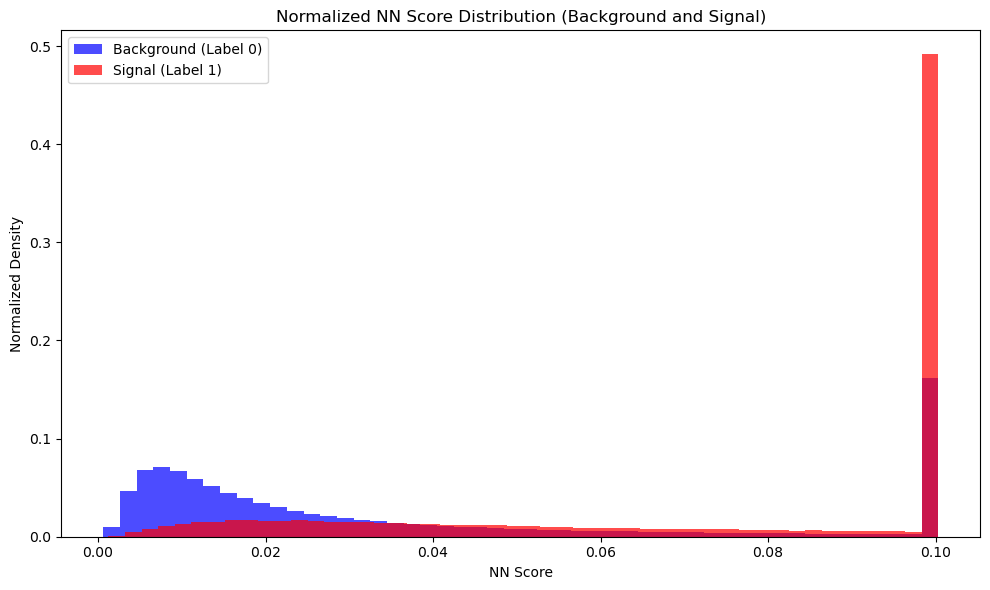

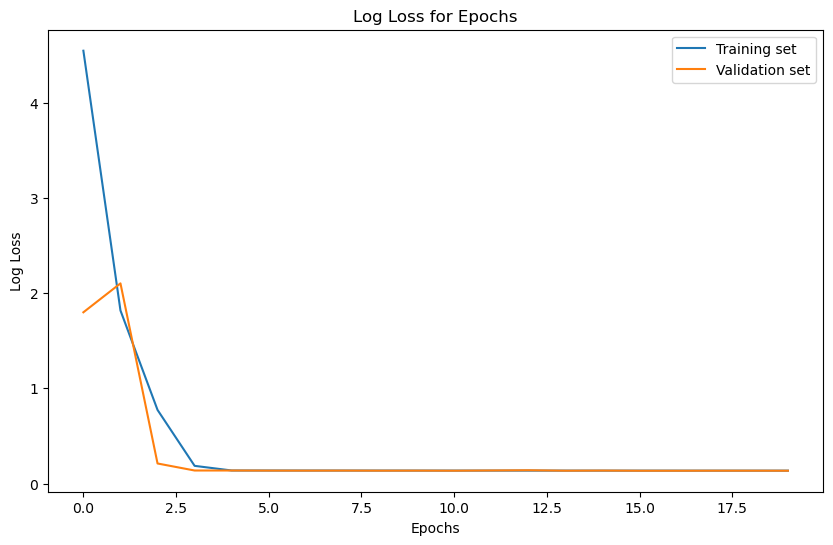

In [6]:
nnPlot = mlpScikitPlotClassifier('nersc.yaml')
nnPlot.train_model()
nnPlot.plot_nn_score()
nnPlot.plot_logloss()

In [ ]:
<<<<<<< local
class mlpScikitClassifier:
=======
# introducing weights, making other model to plot score

class mlpScikitWeightedClassifier:
>>>>>>> remote
    def __init__(self, yaml_file: str): # identifying that the yaml file should be a string
        """
        Initialize with configurations from a YAML file.
        :param yaml_file: Path to the YAML configuration file.
        """
        # defining each of the attributes
        self.input_paths = None
        self.samples = {}
        self.variables = []
        self.hyperparameters = {}
        self.model = None
        self.dataframes = {"background": None, "signal": None}

        # calling two of the functions up here, even though only defined below
        # can do this bc reads classes all first, then goes through
        self._parse_yaml(yaml_file)
        self._load_data()

    def _parse_yaml(self, yaml_file: str):
        try: # try means that if error happens, it'll go to exception
            # use 'with' to make sure that yaml file is closed after it's opened
            with open(yaml_file, 'r' ) as file: # telling to read the file and call it "file"
                config = yaml.safe_load(file)

            # defining the attributes from things inside yaml file
            self.input_paths = config['input_path']
            self.samples[0] = config.get(0, []) # defining first column of samples as those under the key 0 in the yaml file - also, if 0 doesn't exist, return empty list "[]"
            self.samples[1] = config.get(1, []) # defining second column of samples to be things under key 1 in file
            self.variables = config.get('variables', []) # defining variables to be things under key 'variables'

        # if error occurs inside the try, will give this formatted error
        except Exception as e:
            raise ValueError(f"Error parsing YAML file: {e}") # f-string that lets you embed variables in string

    def _load_data(self):
        for sample_type, key in [("background", 0), ("signal", 1)]: # iterating this for loop, once for signal, once for background
            sample_list = self.samples[key] # calling all the background/signal samples
            dataframes = []

            for sample in sample_list:
                files = glob.glob(os.path.join(f"{self.input_paths}/{sample}/", "*.root")) # joining the sample with input path and making root file
                for file in files: ## why do we need this for loop, if there should only be one file found for each sample?
                    self.tree = uproot.open(file)['analysis'] # opening root file and ttree
                    variables_with_b_w = self.variables + ['b_w']
                    df = self.tree.arrays(variables_with_b_w, library="pd") # turning tree into pd df
                    df['sample'] = sample # adding column for sample name
                    df['label'] = key # adding column for 0 or 1
                    dataframes.append(df) # adding all background df into one list

            combined_df = pd.concat(dataframes, ignore_index=True).dropna() # concatinating the list of df into one full df
            self.dataframes[sample_type] = combined_df # making the df an attribute, and placing them in dictionary with the key of either signal or background

    def print_config(self):
        """Prints the current configuration."""
        print(f"Input Paths: {self.input_paths}")
        print(f"Samples: {self.samples}")
        print(f"Variables: {self.variables}")

    def prepare_data(self):
        # putting data into sep background and signal df
        self.background_df = self.dataframes["background"]
        self.signal_df = self.dataframes["signal"]

        # computing ratio between sig and back for reweighting when training model
        #self.scale = len(background_df) / len(signal_df)

        self.combined_df = pd.concat([self.background_df, self.signal_df], ignore_index=True) # combining sig and back df into one df
        # splitting df into X and y
        self.X = self.combined_df[self.variables]  # Use only the specified variables
        self.y = self.combined_df['label']
        self.weights = self.combined_df['b_w']

        # returning the train/test split so can be used later in class
        return train_test_split(self.X, self.y, self.weights, test_size=0.3, random_state=42)

    def train_model(self, model_path="xgboost_model.json", importance_plot_path=None): # function parameters with defaults (if don't pass anything when calling function)
        self.X_train, self.X_test, self.y_train, self.y_test, b_w_train, b_w_test = self.prepare_data() # defining X and y train/test

<<<<<<< local
        def create_baseline():
            model = Sequential()
            inputShape = len(self.variables)
            model.add(Dense(64, input_shape=(inputShape,), activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            return model

        estimator = KerasClassifier(model=create_baseline, epochs=50, batch_size=10, verbose=1)
        kfold = StratifiedKFold(n_splits=10, shuffle=True)
        results = cross_val_score(estimator, self.X_train, self.y_train, cv=kfold)
        print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

        
=======
        inputShape = len(self.variables)
        def create_baseline():
            model = Sequential()
            model.add(tf.keras.Input(shape=(inputShape,)))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(name='auc'),
                                                                                 'accuracy'])

            return model

        #estimator = KerasClassifier(model=create_baseline, epochs=20, batch_size=256, verbose=1)
        #kfold = StratifiedKFold(n_splits=10, shuffle=True)
        #results = cross_val_score(estimator, self.X_train, self.y_train, cv=kfold)
        #print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

        self.nnmodel = create_baseline()
        self.full_model = self.nnmodel.fit(self.X_train, self.y_train, sample_weight=b_w_train, epochs=50, batch_size=50, verbose=1)
    
    def plot_nn_score(self, save_path=None):
        if not hasattr(self, 'model'):
            raise AttributeError("The model has not been trained. Train the model before plotting NN scores.")
    
        # get AUC score
        auc = roc_auc_score(self.y_test, self.nnmodel.predict(self.X_test))
        print(f'AUC: {auc:.3f}')
        
        # Generate scores using the trained model
        self.nn_scores = self.nnmodel.predict(self.X, batch_size=1024).flatten()

        # new df with test set results
        test_df = self.X_test.copy()
        test_df['Label'] = self.y_test
        test_df['nn_score'] = self.nn_scores
        
        # Separate background and signal
        self.combined_df['nn_score'] = self.nn_scores
        background_scores = self.combined_df[self.combined_df['label'] == 0]['nn_score'] # selects rows where 'label' = 0, and then from those rows, only takes the 'BDT score' column
        signal_scores = self.combined_df[self.combined_df['label'] == 1]['nn_score']
    
        # Normalize each group to unity
        background_weights = [1 / len(background_scores)] * len(background_scores) if len(background_scores) > 0 else []
        signal_weights = [1 / len(signal_scores)] * len(signal_scores) if len(signal_scores) > 0 else []
    
        # Plot histograms
        plt.figure(figsize=(10, 6))
        plt.hist(background_scores, bins=50, weights=background_weights, alpha=0.7, label='Background (Label 0)', color='blue')
        plt.hist(signal_scores, bins=50, weights=signal_weights, alpha=0.7, label='Signal (Label 1)', color='red')
    
        plt.xlabel("NN Score")
        plt.ylabel("Normalized Density")
        plt.title("Normalized NN Score Distribution (Background and Signal)")
        plt.legend(loc='best')
        plt.tight_layout()
    
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path)
            print(f"NN score plot saved to {save_path}")
    
        plt.show()

    def plot_logloss(self):
        
        # plotting log loss

        plt.figure(figsize=(10,6))
        plt.plot(self.full_model.history['loss'], label='Training set')
        plt.plot(self.full_model.history['val_loss'], label='Validation set')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss')
        plt.title('Log Loss for Epochs')
        plt.legend()
        plt.show()

    def plt_confusionmatrix(self):
        y_pred_binary = (self.nn_scores > 0.5).astype(int)

        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_binary)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        
        cm_display.plot()
        plt.show()

    def roc_curve(self):
        fpr, tpr, thresholds = roc_curve(self.y_test, self.nn_scores)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        print("AUC score: ", roc_auc_score(y_test, y_pred_proba))
>>>>>>> remote

In [ ]:
<<<<<<< local
mlp = mlpScikitClassifier('nersc.yaml')
=======
mlp = mlpScikitWeightedClassifier('nersc.yaml')
>>>>>>> remote
mlp.train_model()

In [ ]:
mlp.plot_nn_score
mlp.